In [1]:
import os
import pandas as pd
import numpy as np
import sys
sys.path.append('data_augmentation/src')
import utils

<AxesSubplot:>

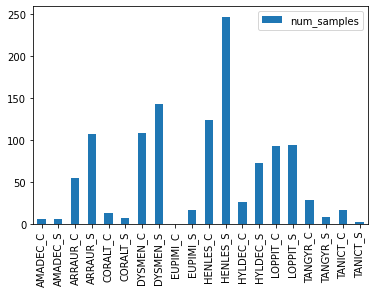

In [2]:
INPUT_DIR_PATH = '../TAKAO_BIRD_WAV_feb20/'

species_df = utils.sample_compositions_by_species(INPUT_DIR_PATH, augmented=False)
species_df.plot.bar()

In [3]:
species_np = species_df.values.flatten()
index_max, index_min = species_df.idxmax().to_numpy()[0], species_df.idxmin().to_numpy()[0]

val_max = np.max(species_np)
max_tenth = val_max//10 +1
val_median = np.median(species_np)

print(f"Median: {val_median},  Min: {np.min(species_np)} ({index_min}) ,  Max: {val_max} ({index_max})")
print(f"10% of max is {max_tenth}")

Median: 27.0,  Min: 0 (EUPIMI_C) ,  Max: 247 (HENLES_S)
10% of max is 25


In [119]:
TO_MEDIAN = True  # True is to make all samples have the median number of samples. 
                  # False is to make all classes have at least 10% of max samples.
# Define the proportions using each augmentation. Proportion used will be num_in_category / total_of_categories
RANDOM_AUGS = False # if this is true, will randomly choose augmentation to use for each new sample
ADD_NOISE   = 1/3
TIME_SHIFT  = 1/3
WARP        = 1/3
MULTIPLE_AUGS = False  # if we want to allow multiple augmentations per sample (ie time shift and warp)
if RANDOM_AUGS:
    OUTPUT_DIR_PATH = f"{INPUT_DIR_PATH[:-1]}_augmented_samples_random"
else:
    assert(ADD_NOISE + TIME_SHIFT + WARP == 1)
    OUTPUT_DIR_PATH = f"{INPUT_DIR_PATH[:-1]}_augmented_samples-{ADD_NOISE:.2f}n-{TIME_SHIFT:.2f}ts-{WARP:.2f}w"
if MULTIPLE_AUGS:
    OUTPUT_DIR_PATH += "/"
else:
    OUTPUT_DIR_PATH += "-exc/"  # indicate that augmentations are mutually exclusive

In [120]:
# Must add data_augmentation/src to system path so that it can find augmentations.py
print(os.getcwd())
import augmentations as aug
import random

/Users/takaoyatagai/Documents/2020-2021/Bird_Research/birds


In [125]:
SAMPLE_THRESHOLD = val_median if TO_MEDIAN else max_tenth
P_DIST    = [ADD_NOISE, TIME_SHIFT, WARP]
AUG_NAMES = ["add_noise", "time_shift", "warp"]
AUG_SPECTROGRAMS_DIR = "spectrograms_augmented/"
AUG_WAV_DIR = "wav_augmented/"
NOISE_PATH = "data_augmentation/lib/Noise_Recordings/"
# Creates output file structure
# OUTPUT_DIR_PATH
#       |-- AUG_WAV_DIR
#       |         |----
#       |         |----
#       |-- AUG_SPECTROGRAMS_DIR
#       |         |----
#       |         |----
utils.create_folder(OUTPUT_DIR_PATH)
utils.create_folder(OUTPUT_DIR_PATH + AUG_WAV_DIR)
utils.create_folder(OUTPUT_DIR_PATH + AUG_SPECTROGRAMS_DIR)

True

In [126]:
def create_augmentations(species, num_samples_orig, threshold):
    species_wav_input_dir  = INPUT_DIR_PATH + species + "/"
    species_wav_output_dir = OUTPUT_DIR_PATH + AUG_WAV_DIR + species + "/"
    species_spectrogram_output_dir = OUTPUT_DIR_PATH + AUG_SPECTROGRAMS_DIR + species + "/"
    # Make output folders under OUTPUT_DIR_PATH
    # Returns if either folder already exists
    if not (utils.create_folder(species_wav_output_dir) and utils.create_folder(species_spectrogram_output_dir)):
        print(f"Skipping augmentations for {species}")
        return

    wav_files = os.listdir(species_wav_input_dir)
    
    # Create original spectrograms
    if num_samples_orig < threshold:
        samples_to_add = int(threshold - num_samples_orig)
        create_original_spectrograms(wav_files, num_samples_orig, 
                                     species_wav_input_dir, species_spectrogram_output_dir)
    else:
        samples_to_add = 0
        create_original_spectrograms(wav_files, threshold,
                                     species_wav_input_dir, species_spectrogram_output_dir)
    print(f"Num Original Samples for {species}: {len(wav_files)}. Creating {samples_to_add} more samples using augmentations.")
    
    # Cannot do augmentations for species with 0 samples
    if len(wav_files) == 0:
        print(f"Skipping for {species} since there are no original samples.")
        return
    # Create samples_to_add samples using augmentations
    for i in range(samples_to_add):
        sample_name = wav_files[i%len(wav_files)]  # if samples to add more than original samples, we may have to augment original samples more than once
        
        # The maximum number of augmentations is equal to using each available augmentation at most once per sample.
        max_num_augs = utils.count_max_augs(P_DIST)
        num_augs_per_sample = np.random.randint(1, max_num_augs+1) if MULTIPLE_AUGS else 1
        
        create_new_sample(sample_name, 
                          (species_wav_input_dir, species_wav_output_dir, species_spectrogram_output_dir),
                          num_augs_per_sample=num_augs_per_sample
                         )
        
def create_new_sample(sample_name, paths, num_augs_per_sample=1):
    (species_wav_input_dir, species_wav_output_dir, species_spectrogram_output_dir) = paths
    aug_choices = np.random.choice(AUG_NAMES, size=num_augs_per_sample, p=P_DIST, replace=False)
#     input(f"Aug chioces: {aug_choices}")
    # Warping must be done after all the other augmentations take place, after spectrogram is created
    warp = False
    if "warp" in aug_choices:
        warp = True
        aug_choices = aug_choices.tolist()
#         print(f"Aug chioces as list: {aug_choices}")
        aug_choices.remove("warp")
#         print(f"Aug chioces after: {aug_choices}")
        
    for i in range(len(aug_choices)):
#         print(aug_choices)
        aug_name = aug_choices[i]
        if i != 0:  # if not first augmentation, then, source wav is in output wav directory
            species_wav_input_dir = species_wav_output_dir
        if aug_name == "add_noise":
            #add_noise which noise to add will be chosen at random
            updated_name = aug.add_background(sample_name, NOISE_PATH, species_wav_input_dir, species_wav_output_dir, len_noise_to_add=5.0)
        elif aug_name == "time_shift":
            #time_shift
            updated_name = aug.time_shift(sample_name, species_wav_input_dir, species_wav_output_dir)
        sample_name = updated_name
        
    # create new spectrogram if augmented
    if len(aug_choices) != 0:
        sample_name = aug.create_spectrogram(sample_name, species_wav_output_dir, species_spectrogram_output_dir, n_mels=128)
        
    if warp:
        #warp
#         if len(aug_choices) +1 > 1:
#             input(f"num_augs = {len(aug_choices) +1} for {sample_name}")
        sample_name = sample_name[:-len(".wav")] + ".png"
        # Above: if sample is unaugmented to this point, sample_name will be
        # *.wav. Since warp_spectrogram expects sample_name to be *.png, we 
        # replace extension. If augmented and sample_name is already *.png, 
        # there is no change.
        warped_name = aug.warp_spectrogram(sample_name, species_spectrogram_output_dir, species_spectrogram_output_dir)
        if len(aug_choices) != 0: # if warp is not the only augmentation, we do not want spectrogram before warp
            assert(warped_name != sample_name)
            os.remove(species_spectrogram_output_dir + sample_name)

def create_original_spectrograms(samples, n, species_wav_input_dir, species_spectrogram_output_dir):
    samples = random.sample(samples, int(n)) # choose n from all samples
    for sample_name in samples:
        aug.create_spectrogram(sample_name, species_wav_input_dir, species_spectrogram_output_dir, n_mels=128)

/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audio

Num Original Samples for AMADEC_C: 6. Creating 21 more samples using augmentations.


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(

/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3;

Amaziliadecora482993.png
Amaziliadecora557128.png


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audio

Amaziliadecora557128.png


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


Amaziliadecora541736.png


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audio

Num Original Samples for AMADEC_S: 6. Creating 21 more samples using augmentations.


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/d

Amaziliadecora166620.png
Amaziliadecora106187.png


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/d

Amaziliadecora106187.png
Amaziliadecora167555.png
Amaziliadecora561264.png


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audio

Amaziliadecora166620.png


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/d

Amaziliadecora167555.png
Amaziliadecora561264.png
Amaziliadecora106188.png


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


Amaziliadecora166620.png


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audio

/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3;

/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3;

Num Original Samples for ARRAUR_C: 55. Creating 0 more samples using augmentations.


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3;

/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3;

/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audio

Num Original Samples for ARRAUR_S: 107. Creating 0 more samples using augmentations.


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audio

/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3;

Num Original Samples for CORALT_C: 13. Creating 14 more samples using augmentations.


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audio

Corapipoaltera494823.png


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audio

Corapipoaltera16078.png


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audio

Corapipoaltera274664.png


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/d

Corapipoaltera13180.png


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audio

Num Original Samples for CORALT_S: 7. Creating 20 more samples using augmentations.
Corapipoaltera82934.png


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/d

Corapipoaltera82934.png


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


Corapipoaltera82935.png


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audio

Corapipoaltera221643.png


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/d

Corapipoaltera221644.png


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/d

/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3;

/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audio

Num Original Samples for DYSMEN_C: 108. Creating 0 more samples using augmentations.


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audio

/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3;

/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audio

Num Original Samples for DYSMEN_S: 143. Creating 0 more samples using augmentations.
Num Original Samples for EUPIMI_C: 0. Creating 27 more samples using augmentations.
Skipping for EUPIMI_C since there are no original samples.


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audio

/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3;

Num Original Samples for EUPIMI_S: 16. Creating 11 more samples using augmentations.
Euphoniaimitans166048.png


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audio

Euphoniaimitans340132.png


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/d

Euphoniaimitans107554.png


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/d

/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3;

/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audio

Num Original Samples for HENLES_C: 124. Creating 0 more samples using augmentations.


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3;

/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audio

/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3;

Num Original Samples for HENLES_S: 247. Creating 0 more samples using augmentations.


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3;

/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audio

/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3;

Num Original Samples for HYLDEC_C: 26. Creating 1 more samples using augmentations.


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(

/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audio

/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3;

Num Original Samples for HYLDEC_S: 72. Creating 0 more samples using augmentations.


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3;

/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3;

/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3;

Num Original Samples for LOPPIT_C: 93. Creating 0 more samples using augmentations.


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audio

/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3;

/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audio

Num Original Samples for LOPPIT_S: 94. Creating 0 more samples using augmentations.


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3;

/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3;

/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3;

Num Original Samples for TANGYR_C: 28. Creating 0 more samples using augmentations.


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3;

Num Original Samples for TANGYR_S: 8. Creating 19 more samples using augmentations.
Tangaragyrola7132.png


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/d

Tangaragyrola83995.png
Tangaragyrola98225.png
Tangaragyrola118930.png


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audio

Tangaragyrola253647.png


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/d

Tangaragyrola490026.png


UnboundLocalError: local variable 'mask_end' referenced before assignment

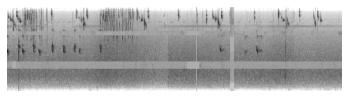

In [127]:
for species, rows in species_df.iterrows():
    num_samples_orig = rows['num_samples']
    create_augmentations(species, num_samples_orig, SAMPLE_THRESHOLD)
#     input(f"Finished for {species}")

          add_bg  time_shift  mask  original  total_samples
AMADEC_C       9           8     4         6             27
AMADEC_S       4           7    10         6             27
ARRAUR_C       0           0     0        27             27
ARRAUR_S       0           0     0        27             27
CORALT_C       5           5     4        13             27
CORALT_S       8           7     5         7             27
DYSMEN_C       0           0     0        27             27
DYSMEN_S       0           0     0        27             27
EUPIMI_C       0           0     0         0              0
EUPIMI_S       2           6     3        16             27
HENLES_C       0           0     0        27             27
HENLES_S       0           0     0        27             27
HYLDEC_C       0           1     0        26             27
HYLDEC_S       0           0     0        27             27
LOPPIT_C       0           0     0        27             27
LOPPIT_S       0           0     0      

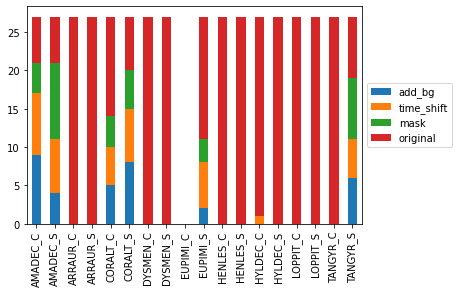

In [130]:
os.system(f"find {OUTPUT_DIR_PATH + AUG_SPECTROGRAMS_DIR} -name \".DS_Store\" -delete")
augmented_df = utils.sample_compositions_by_species(OUTPUT_DIR_PATH + AUG_SPECTROGRAMS_DIR, augmented=True)
augmented_df["total_samples"] = augmented_df.sum(axis=1)
print(augmented_df)
augmented_df.plot.bar(y=["add_bg", "time_shift", "mask", "original"],stacked=True).legend(loc='center left', bbox_to_anchor=(1, 0.5))

../TAKAO_BIRD_WAV_feb20_augmented_samples-0.33n-0.33ts-0.33w-exc/wav_augmented/TANGYR_S/ already exists. Do you want to rewrite ../TAKAO_BIRD_WAV_feb20_augmented_samples-0.33n-0.33ts-0.33w-exc/wav_augmented/TANGYR_S/? [y/N]  y
../TAKAO_BIRD_WAV_feb20_augmented_samples-0.33n-0.33ts-0.33w-exc/spectrograms_augmented/TANGYR_S/ already exists. Do you want to rewrite ../TAKAO_BIRD_WAV_feb20_augmented_samples-0.33n-0.33ts-0.33w-exc/spectrograms_augmented/TANGYR_S/? [y/N]  y


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audio

Num Original Samples for TANGYR_S: 8. Creating 19 more samples using augmentations.


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


Tangaragyrola98011.png
Tangaragyrola16398.png
Tangaragyrola253647.png


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audio

Tangaragyrola118930.png


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/d

Tangaragyrola253647.png


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/d

Tangaragyrola118930.png


/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/display.py:862: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/takaoyatagai/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audio

Tangaragyrola98011.png
Tangaragyrola16398.png


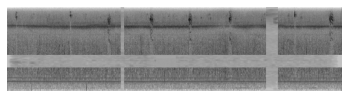

In [129]:
create_augmentations("TANGYR_S", 8, SAMPLE_THRESHOLD)